In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from pulp import *

In [2]:
# importing the data to take a look at what we have

df = pd.read_csv('../data/family_data.csv',index_col=0)

df.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,52,38,12,82,33,75,64,76,10,28,4
1,26,4,82,5,11,47,38,6,66,61,4
2,100,54,25,12,27,82,10,89,80,33,3
3,2,95,1,96,32,6,40,31,9,59,2
4,53,1,47,93,26,3,46,16,42,39,4


In [3]:
# for testing
num_days=20
num_families = 100

In [4]:
df2 = df[:num_families].copy()

In [8]:
#people scaling 
people_scale = df2.n_people.sum()/df.n_people.sum()

max_people = 1.7*df2.n_people.sum()/num_days
min_people = df2.n_people.sum()/2/num_days

# day scaling
day_scale = num_days/100

In [9]:
print(max_people)
print(min_people)
print(day_scale)
print(people_scale)

33.745
9.925
0.2
0.018902061610246157


In [10]:
if num_days!=100:
    for c in df2.columns.tolist()[:10]:
        df2[c] = np.random.randint(1,num_days+1,num_families)

In [11]:
df2.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
family_id,,,,,,,,,,,
0,1,17,15,10,19,18,19,11,13,9,4
1,18,7,14,7,9,9,11,15,2,18,4
2,1,12,6,1,14,14,17,17,18,16,3
3,8,18,14,18,2,14,8,18,3,15,2
4,19,1,7,12,15,18,19,10,7,20,4


In [12]:
# I'm going to add a column which will represent the choice falling outside of any of the given choices. 
# This will be choice_10, and it will be 101,,,

In [13]:
df2.describe()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people
count,100.000000,100.000000,100.00000,100.000000,100.000000,100.0000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,10.760000,10.130000,10.49000,10.930000,11.160000,11.0800,10.740000,10.430000,11.540000,11.430000,3.970000
std,6.032103,5.866624,5.50022,5.659095,5.790483,5.5134,5.955424,5.742373,6.307635,6.238128,1.572844
min,1.000000,1.000000,1.00000,1.000000,1.000000,1.0000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,5.000000,5.000000,6.75000,6.000000,6.000000,7.0000,5.000000,6.000000,6.000000,5.000000,3.000000
50%,12.000000,9.500000,10.00000,11.000000,11.000000,11.0000,11.000000,10.000000,13.000000,13.000000,4.000000
75%,16.000000,16.000000,15.00000,15.250000,16.000000,16.0000,16.000000,15.000000,17.000000,17.000000,5.000000
max,20.000000,20.000000,20.00000,20.000000,20.000000,20.0000,20.000000,20.000000,20.000000,20.000000,8.000000


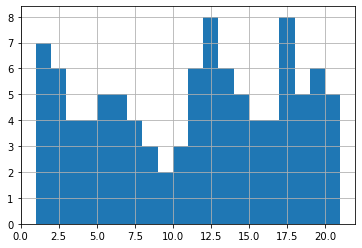

In [14]:
df2['choice_0'].hist(bins=[b for b in range(1,num_days+2,1)])

In [15]:
lower_limit = min_people
upper_limit = max_people

# creating the decision variables
choice = ['choice_0','choice_1', 'choice_2', 'choice_3', 'choice_4', 'choice_5', 
          'choice_6', 'choice_7', 'choice_8', 'choice_9','choice_10']
day = [i for i in range(1,num_days+1)]
fam_id = df2.index.tolist()

The decision variable needs to be a boolean for each choice for each family. We will create a 

In [16]:
# The prob variable is created to contain the problem data        
prob = LpProblem("Santa",LpMinimize)

In [17]:
# The decision variables are actually the family and the day they are assigned
selection = LpVariable.dicts("sel",(fam_id,day),0,1,LpInteger)

In [18]:
# adding in the constraints

# The first set of constraints ensures each family only has a single day selected
for f in fam_id:
        prob += lpSum([selection[f][d] for d in day]) == 1, ''

In [19]:
# the second set of constraints guarantee that the total number of visitors is between 125 and 300 for
# for every single day leading up to christmas

for d in day:
    prob += lpSum([selection[f][d]*df2['n_people'][f] for f in fam_id]) >= lower_limit, ''
    prob += lpSum([selection[f][d]*df2['n_people'][f] for f in fam_id]) <= upper_limit, ''

Now we need to write down the objective function. How do we figure out how to flag for choice? Can we create a vector of choice for each family member?

Can we do some sort of mod of the day in the choice dictionary over the selected day?

I think we need to place a vector of length 11 in every single day for every single family. The location that is 1 will be the choice for that day. If the day is not one of the choices, the 11th element will be 1. This will then be used to multiply by the matrix for penalties.

Need to do some sort of 

In [20]:
choice_matrix = {}

for f in fam_id:
    
    if f%100==0:
        print('{}/{}'.format(f,len(df2)))
    
    choice_matrix[f] = {}
    
    for d in day:
        
        choice_to_check = df2.loc[f,df2.columns.tolist()[:10]].values
        
        if d in choice_to_check:
            c_loc = np.where(choice_to_check==d)[0][0]
        else:
            c_loc = 10
            
            
        choice_matrix[f][d] = {c:(0 if i!=c_loc else 1) for i,c in enumerate(choice)} 

0/100


In [21]:
choice_matrix[0][16]

{'choice_0': 0,
 'choice_1': 0,
 'choice_2': 0,
 'choice_3': 0,
 'choice_4': 0,
 'choice_5': 0,
 'choice_6': 0,
 'choice_7': 0,
 'choice_8': 0,
 'choice_9': 0,
 'choice_10': 1}

In [22]:
# gift card contribution by choice
choice_gc = {}
choice_gc['choice_0'] = 0
choice_gc['choice_1'] = 50
choice_gc['choice_2'] = 50
choice_gc['choice_3'] = 100
choice_gc['choice_4'] = 200
choice_gc['choice_5'] = 200
choice_gc['choice_6'] = 300
choice_gc['choice_7'] = 300
choice_gc['choice_8'] = 400
choice_gc['choice_9'] = 500
choice_gc['choice_10'] = 500

# per member monetary contribution
choice_pm = {}
choice_pm['choice_0'] = 0
choice_pm['choice_1'] = 0
choice_pm['choice_2'] = 9
choice_pm['choice_3'] = 9
choice_pm['choice_4'] = 9
choice_pm['choice_5'] = 18
choice_pm['choice_6'] = 18
choice_pm['choice_7'] = 36
choice_pm['choice_8'] = 36
choice_pm['choice_9'] = 36+199
choice_pm['choice_10'] = 36+398


In [23]:
def ppd(d):
    if d>num_days:
        d=num_days
    return lpSum([selection[f][d]*df2['n_people'][f] for f in fam_id])


def accounting_penalty():
    return lpSum( [ 400/max_people*(0.055*(ppd(d)+(125-min_people)) - 6.8) for d in day] )

In [24]:

prob += lpSum([selection[f][d]*choice_matrix[f][d][c]*(choice_gc[c]+df2['n_people'][f]*choice_pm[c])
               for c in choice for d in day for f in fam_id]) \
        + accounting_penalty() \
                 , 'Objective Function'

In [ ]:
prob += lpSum([selection[f][d]*choice_matrix[f][d][c]*(choice_gc[c]+df2['n_people'][f]*choice_pm[c])
               for c in choice for d in day for f in fam_id]) \
        , 'Objective Function'

In [25]:
import time



In [26]:
tm = time.time()
print(tm)

prob.solve()

tm_final = time.time()
print(tm_final)

print('Total Minutes: {}'.format( (tm_final-tm)/60))

1576179620.3685122
1576179620.543252
Total Minutes: 0.0029123306274414064


In [27]:
# The status of the solution is printed to the screen
print("Status:", LpStatus[prob.status])

Status: Optimal


In [28]:
obj = value(prob.objective)
print(obj)

247.1921766187586


In [30]:
fam_day_dict = {}

for f in fam_id:
    for d in day:
        if value(selection[f][d])==1:
            fam_day_dict[f] = d

In [34]:
sel_series = pd.Series(fam_day_dict,name='selection')

In [35]:
sel_series

0      1
1     18
2      1
3      8
4     19
      ..
95     2
96    11
97    17
98    13
99    17
Name: selection, Length: 100, dtype: int64

In [36]:
df2 = df2.join(sel_series)

In [37]:
df2.head()

,choice_0,choice_1,choice_2,choice_3,choice_4,choice_5,choice_6,choice_7,choice_8,choice_9,n_people,selection
family_id,,,,,,,,,,,,
0,1,17,15,10,19,18,19,11,13,9,4,1
1,18,7,14,7,9,9,11,15,2,18,4,18
2,1,12,6,1,14,14,17,17,18,16,3,1
3,8,18,14,18,2,14,8,18,3,15,2,8
4,19,1,7,12,15,18,19,10,7,20,4,19


In [ ]:
t = df.loc[0,df.columns.tolist()[:10]].values

In [ ]:
val = 28

if val in t:
    loc = np.where(t==val)[0][0]
else:
    loc = 10
    
print(loc)

In [ ]:
501%50

In [ ]:
x = [0,1,2]
y = [3,4,5]
z = [6,7,8]

In [ ]:
l = [a*b*c for a in x for b in y for c in z]

In [ ]:
len(l)

In [ ]:
2**(2+1)

In [ ]:
abs(-10.1)

In [ ]:
200*500 + df.n_people.sum()*choice_pm['choice_10']

In [ ]:
df.n_people.sum()

In [ ]:
df.n_people.sum()/20

In [ ]:
def accounting_penalty(x):
    return (x-125)/400 * x**(0.5)*x**(10*np.exp(-(x-125)/100)/50)

def accounting_penalty_lin(x):
    return 400/max_people*(0.055*(x+(125-min_people))-6.8)

In [ ]:
x1 = np.arange(125,400,1)
x2 = np.arange(min_people,max_people,1)

In [ ]:
y1 = accounting_penalty(x1)
y2 = accounting_penalty_lin(x2)

In [ ]:
y = lambda x: x**(1/5)

In [ ]:
#plt.plot(x1,y1)
plt.plot(x2,y2)

In [ ]:
plt.plot(x,y)

In [ ]:
max(y)

In [ ]:
15/275

In [ ]:
15/275*125

In [ ]:
plt.plot(x1,(x1-125)/400 * x1**(0.5))

In [ ]:
(400-125)/100

In [ ]:
c = df['']

Some boneheaded approximations would estimate the accounting penalty to be y(d) = 0.55*d-6.8

In [ ]:
# day scaling
day_scale = num_days/100

In [ ]:
#people scaling 
people_scale = df2.n_people.sum()/df.n_people.sum()

In [ ]:
125*people_scale

In [ ]:
df.n_people.sum()

In [ ]:
21003/100

In [ ]:
200/20

In [ ]:
min_people

In [ ]:
max_people

In [ ]:
v = prob.variables()[0]

In [ ]:
v.name

In [ ]:
print(v.varValue)